# Regresion Basica: Predecir eficiencia de gasolina

Este libro usa el set de datos clasico [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) y construye un modelo para predecir el consumo de vehiculos de 1970 y 1980. Para hacer esto proveeremos el modelo con una descripcion de muchos automoviles de ese periodo. Esta descripcion incluye atributos como: Cilindros, desplazamiento, potencia y peso.

El objetivo de este ejercicio es predecir el target miles per galon (MPG), que vendría a representar las millas por galón de combustible.

Este ejemplo usa el API `tf.keras` , revise [Esta Guia](https://www.tensorflow.org/guide/keras) para obtener mas detalles.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras

## El set de Datos de MPG

El set de datos esta disponible de el siguiente repositorio [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).

### Obtenga los datos
Primero descargue el set de datos.
keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

In [2]:
dataset = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset

  16384/Unknown 0s 9us/step

'C:\\Users\\mikel\\.keras\\datasets\\auto-mpg.data'

Importelo usando pandas.

In [5]:
# Define los nombres de las columnas
column_names = [
    "MPG", "Cylinders", "Displacement", "Horsepower", "Weight",
    "Acceleration", "Model Year", "Origin"
]

# Cargar el archivo en un DataFrame de pandas
dataset_df = pd.read_csv(
    dataset,  # Utiliza la variable 'dataset' que contiene la ruta del archivo descargado
    names=column_names, 
    na_values="?", 
    comment="\t", 
    sep=" ", 
    skipinitialspace=True
)

# Mostrar las primeras filas del conjunto de datos
print(dataset_df.head())

    MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   Model Year  Origin  
0          70       1  
1          70       1  
2          70       1  
3          70       1  
4          70       1  


### Limpia los datos

Trata los missings y variables categóricas

In [7]:
# Copiar el dataset cargado para trabajar con él
cleaned_dataset = pd.read_csv(
    dataset,  # Utilizando la ruta cargada
    names=column_names, 
    na_values="?", 
    comment="\t", 
    sep=" ", 
    skipinitialspace=True
)

# Eliminar filas con valores faltantes
cleaned_dataset.dropna(inplace=True)

# Convertir la columna 'Origin' en variables categóricas
# Según la documentación: 1 = USA, 2 = Europe, 3 = Japan
cleaned_dataset['Origin'] = cleaned_dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

# Convertir la columna 'Origin' en variables dummy (one-hot encoding)
cleaned_dataset = pd.get_dummies(cleaned_dataset, columns=['Origin'], prefix='', prefix_sep='')

# Mostrar las primeras filas del conjunto de datos limpio
print(cleaned_dataset.head())



    MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   Model Year  Europe  Japan   USA  
0          70   False  False  True  
1          70   False  False  True  
2          70   False  False  True  
3          70   False  False  True  
4          70   False  False  True  


### Divide los datos en train y test

Ahora divida el set de datos en un set de entrenamiento y otro de pruebas. 80% para entrenamiento

Usaremos el set de pruebas en la evaluacion final de nuestro modelo.

NOTA: El resultado tienen que ser dos datasets

In [8]:
# Dividir los datos en conjuntos de entrenamiento (80%) y prueba (20%)
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(cleaned_dataset, test_size=0.2, random_state=42)

# Mostrar las formas de los conjuntos de datos
print("Forma del conjunto de entrenamiento:", train_dataset.shape)
print("Forma del conjunto de prueba:", test_dataset.shape)

Forma del conjunto de entrenamiento: (313, 10)
Forma del conjunto de prueba: (79, 10)


### Inspecciona los datos

Revise rapidamente la distribucion conjunta del dataset de entrenamiento mediante un grid de gráficos

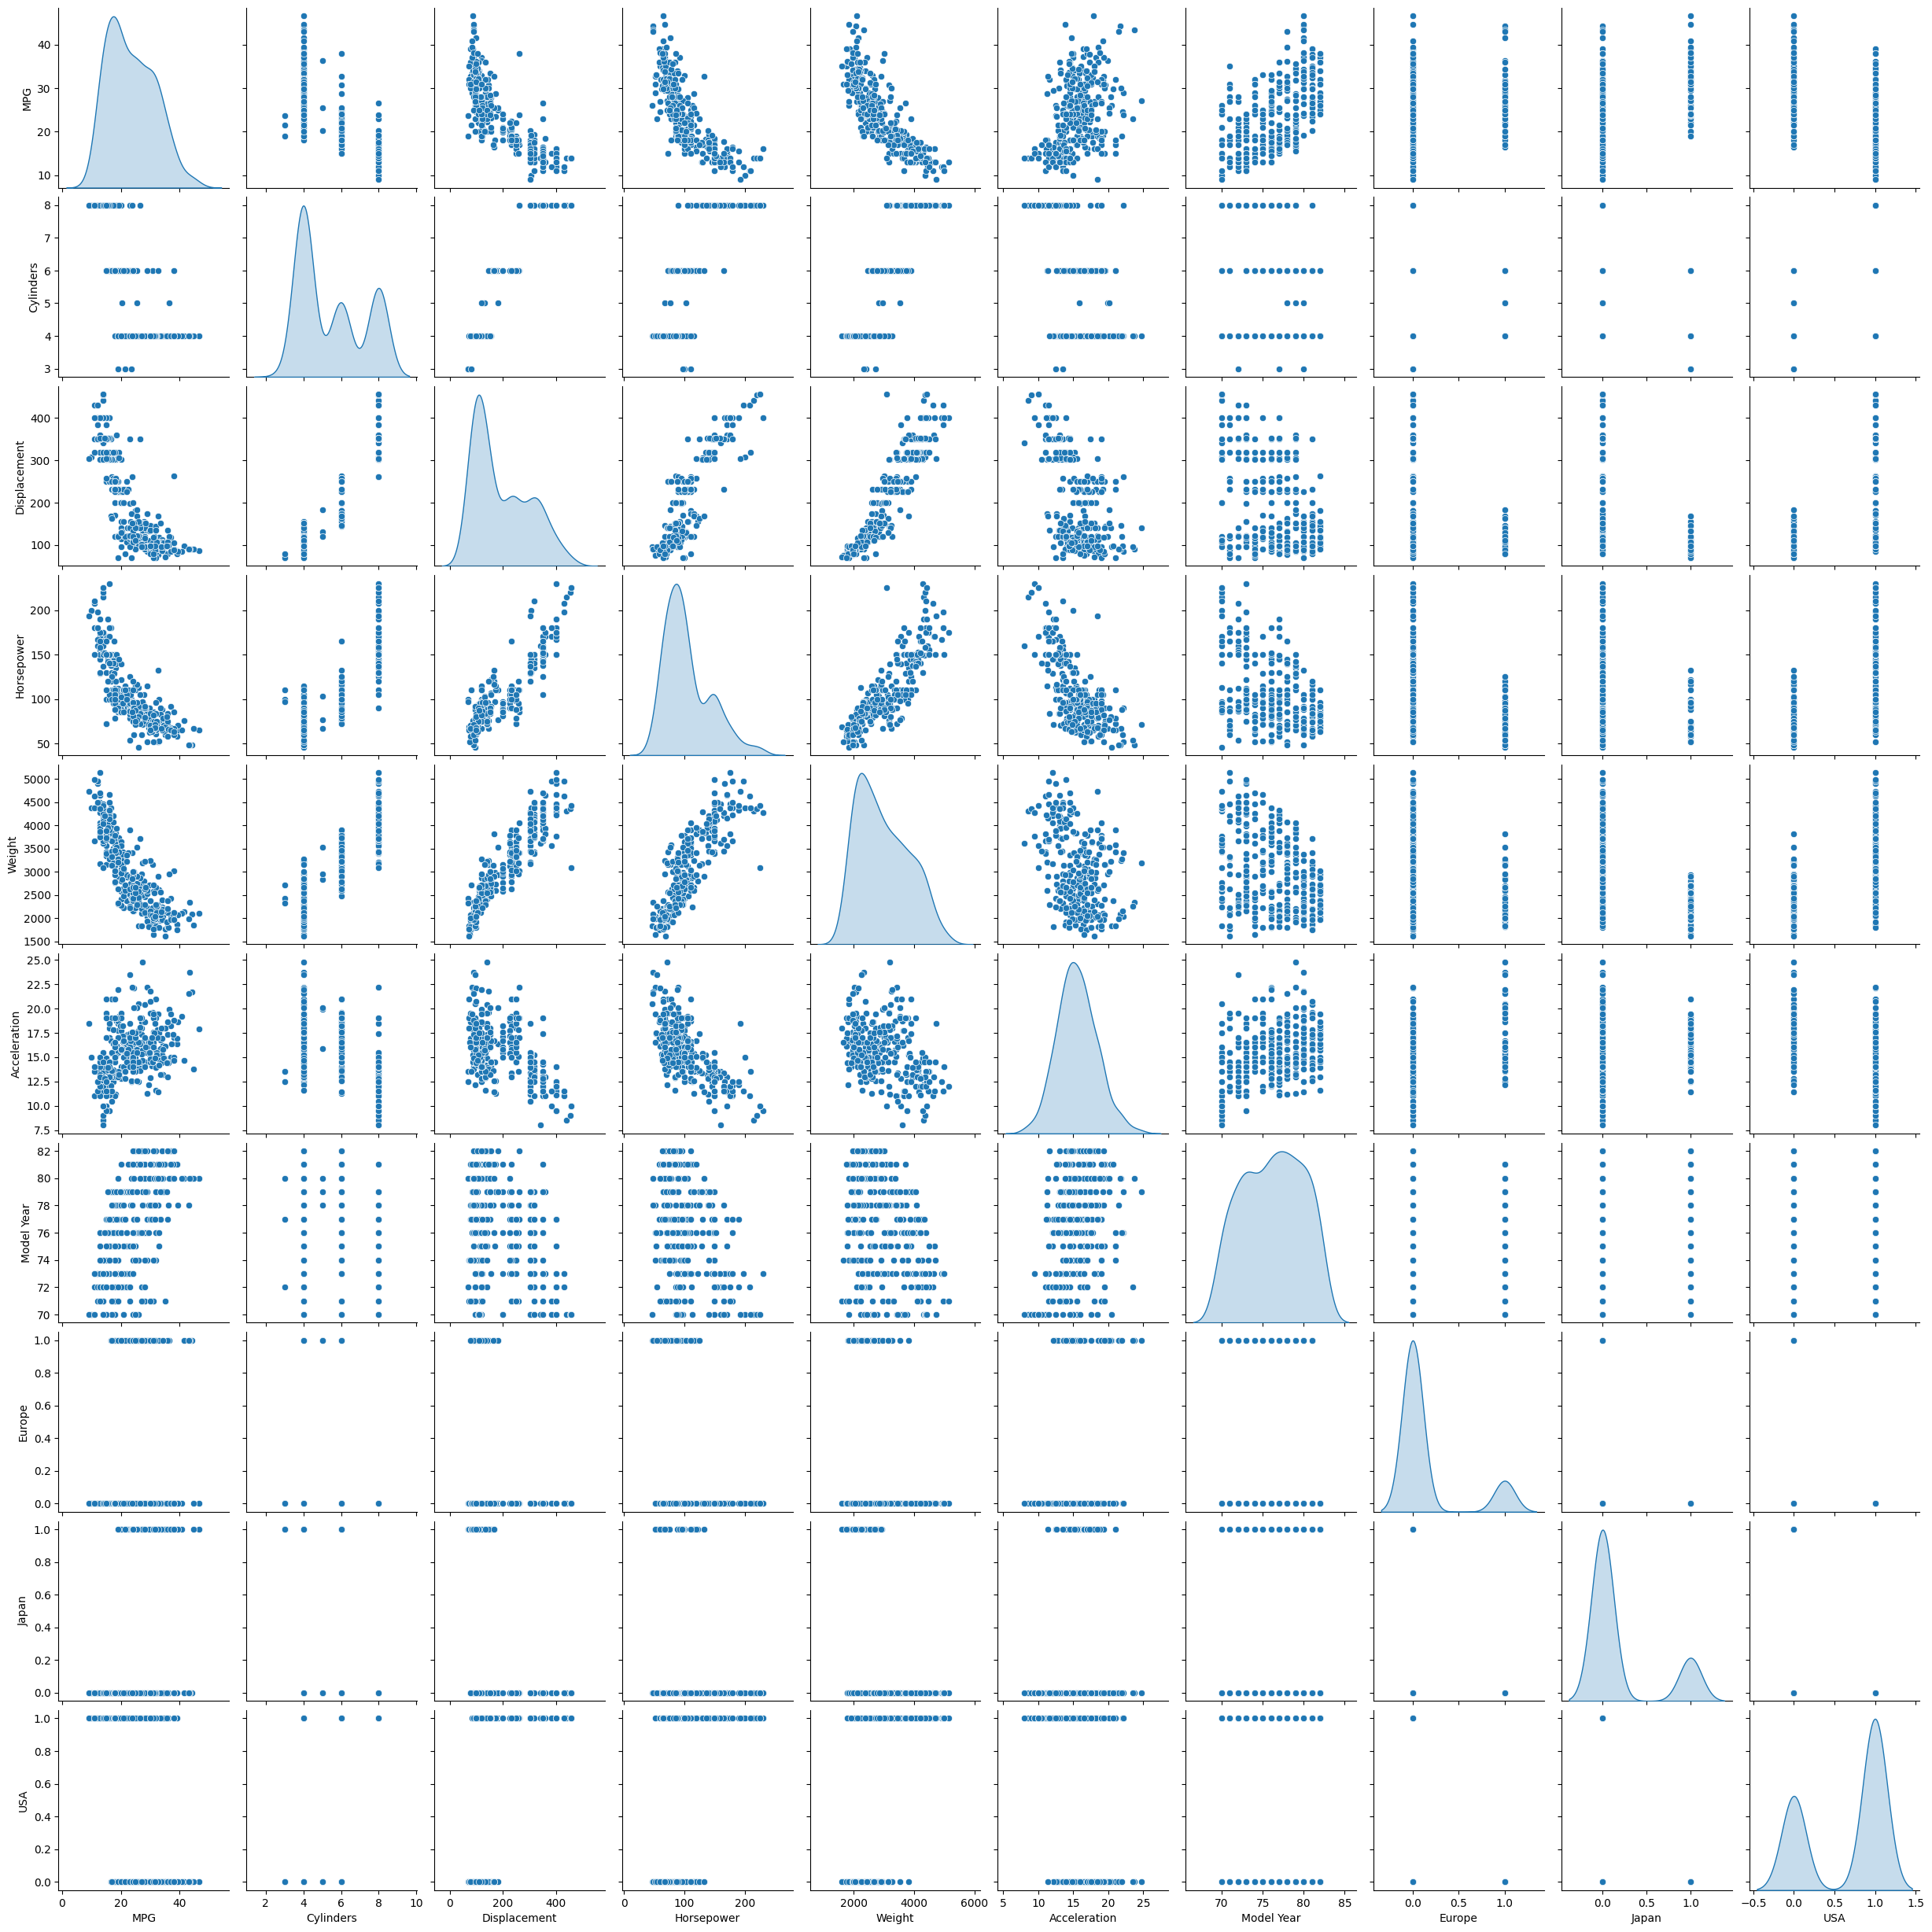

In [9]:
# Inspeccionar los datos: grid de gráficos
sns.pairplot(train_dataset, diag_kind="kde")
plt.show()


Tambien revise las estadisticas generales:

In [10]:
# Revisar las estadísticas generales del conjunto de entrenamiento
train_stats = train_dataset.describe().transpose()

# Mostrar las estadísticas generales
print(train_stats)

              count         mean         std     min     25%     50%     75%  \
MPG           313.0    23.599361    7.956255     9.0    17.0    23.0    30.0   
Cylinders     313.0     5.482428    1.700446     3.0     4.0     4.0     8.0   
Displacement  313.0   195.517572  103.766567    70.0   105.0   151.0   302.0   
Horsepower    313.0   104.594249   38.283669    46.0    76.0    95.0   129.0   
Weight        313.0  2986.124601  841.133957  1613.0  2234.0  2855.0  3645.0   
Acceleration  313.0    15.544089    2.817864     8.0    13.5    15.5    17.3   
Model Year    313.0    76.207668    3.630136    70.0    73.0    76.0    79.0   

                 max  
MPG             46.6  
Cylinders        8.0  
Displacement   455.0  
Horsepower     230.0  
Weight        5140.0  
Acceleration    24.8  
Model Year      82.0  


### Separa las features del target

Separe el target de las features.

In [11]:
# Separar las características (features) del objetivo (target)
train_features = train_dataset.drop(columns=["MPG"])
train_target = train_dataset["MPG"]

test_features = test_dataset.drop(columns=["MPG"])
test_target = test_dataset["MPG"]

# Mostrar las formas de los datasets resultantes
print("Train features shape:", train_features.shape)
print("Train target shape:", train_target.shape)
print("Test features shape:", test_features.shape)
print("Test target shape:", test_target.shape)

Train features shape: (313, 9)
Train target shape: (313,)
Test features shape: (79, 9)
Test target shape: (79,)


### Estandariza los datos

Es una buena práctica estandarizar funciones que utilizan diferentes escalas y rangos. Aunque el modelo podría converger sin estandarizar, dificulta el entrenamiento y hace que el modelo resultante dependa de la elección de las unidades utilizadas en la entrada.

In [12]:
from sklearn.preprocessing import StandardScaler

# Crear un escalador
scaler = StandardScaler()

# Ajustar el escalador solo con los datos de entrenamiento y transformar
train_features = pd.DataFrame(scaler.fit_transform(train_features), columns=train_features.columns)

# Usar el mismo escalador para transformar los datos de prueba
test_features = pd.DataFrame(scaler.transform(test_features), columns=test_features.columns)

# Mostrar un resumen de los datos estandarizados
print(train_features.describe().transpose())

              count          mean       std       min       25%       50%  \
Cylinders     313.0  1.475568e-16  1.001601 -1.462206 -0.873184 -0.873184   
Displacement  313.0  3.972683e-17  1.001601 -1.211552 -0.873716 -0.429703   
Horsepower    313.0 -1.475568e-16  1.001601 -1.532979 -0.748101 -0.251011   
Weight        313.0  2.553868e-16  1.001601 -1.635082 -0.895611 -0.156140   
Acceleration  313.0  5.646885e-16  1.001601 -2.681524 -0.726565 -0.015671   
Model Year    313.0 -1.801896e-15  1.001601 -1.712775 -0.885037 -0.057298   
Europe        313.0 -1.418815e-17  1.001601 -0.425596 -0.425596 -0.425596   
Japan         313.0 -4.823972e-17  1.001601 -0.501996 -0.501996 -0.501996   
USA           313.0  1.177617e-16  1.001601 -1.349007 -1.349007  0.741286   

                   75%       max  
Cylinders     1.482907  1.482907  
Displacement  1.027816  2.504640  
Horsepower    0.638519  3.280944  
Weight        0.784572  2.564781  
Acceleration  0.624133  3.289986  
Model Year    0.770

## El modelo

### Construye el modelo

Construyamos nuestro modelo. Aquí, utilizaremos un modelo `secuencial` con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo.

Por tanto, tendrá tres capas. Una de entrada con activación relu. Otra hidden layer con activación relu y la de salida de regresión, que se compondrá de una única neurona. Pon las neuronas que consideres para las dos primeras capas.

Para el compile utiliza un loss='mse'.

optimizer = `tf.keras.optimizers.RMSprop(0.001)`

Y en metrics añade en una lista el `mae` y `mse`.

In [13]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop

# Construcción del modelo secuencial
model = Sequential([
    Dense(64, activation='relu', input_shape=[train_features.shape[1]]),  # Primera capa oculta
    Dense(64, activation='relu'),  # Segunda capa oculta
    Dense(1)  # Capa de salida para regresión
])

# Compilación del modelo
model.compile(
    optimizer=RMSprop(0.001),
    loss='mse',
    metrics=['mae', 'mse']
)

# Mostrar un resumen del modelo
model.summary()


c:\Users\mikel\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,865 (19.00 KB)

 Trainable params: 4,865 (19.00 KB)

 Non-trainable params: 0 (0.00 B)

### Inspeccione el modelo

Use el método `.summary` para imprimir una descripción simple del modelo

In [14]:
# Inspeccionar el modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,865 (19.00 KB)

 Trainable params: 4,865 (19.00 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenar el modelo

Entrene el modelo para 1000 epochs y guarda los resultados del entrenamiento en una variable llamada `history`.
Emplea en el entrenamiento un 20% de los datos para validación, mediante el argumento `validation_split`.

NOTA: recuerda usar los datos normalizados.

In [16]:
# Entrenar el modelo
history = model.fit(
    train_features, train_target,  # Datos de entrenamiento
    epochs=1000,                  # Número de épocas
    validation_split=0.2,         # Usar el 20% de los datos para validación
    verbose=1                     # Mostrar el progreso del entrenamiento
)


Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.4913 - mae: 1.3522 - mse: 4.4913 - val_loss: 7.2773 - val_mae: 1.8576 - val_mse: 7.2773
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.4845 - mae: 1.3861 - mse: 4.4845 - val_loss: 7.0462 - val_mae: 1.8096 - val_mse: 7.0462
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.0635 - mae: 1.4628 - mse: 5.0635 - val_loss: 6.6228 - val_mae: 1.8234 - val_mse: 6.6228
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.0271 - mae: 1.3657 - mse: 4.0271 - val_loss: 7.0594 - val_mae: 1.8223 - val_mse: 7.0594
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.6600 - mae: 1.4347 - mse: 4.6600 - val_loss: 8.6367 - val_mae: 2.0554 - val_mse: 8.6367
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.2816 - mae: 1.4710 - mse: 5.2816 - val_loss: 8.8279 - val_mae: 2.0832 - val_mse: 8.8279
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.4728 - mae: 1.4403 - mse: 4.4728 - val_loss: 

Visualice el progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto `history`.

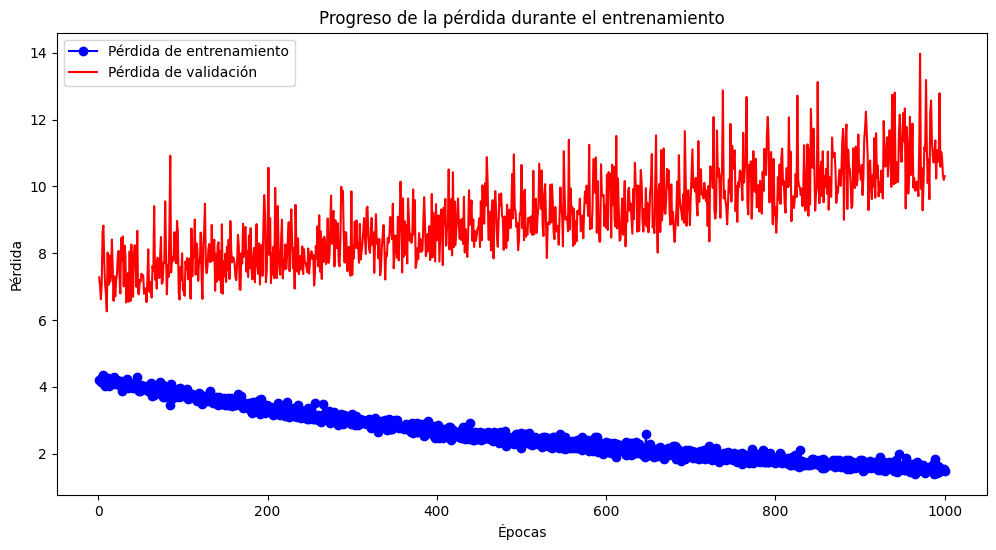

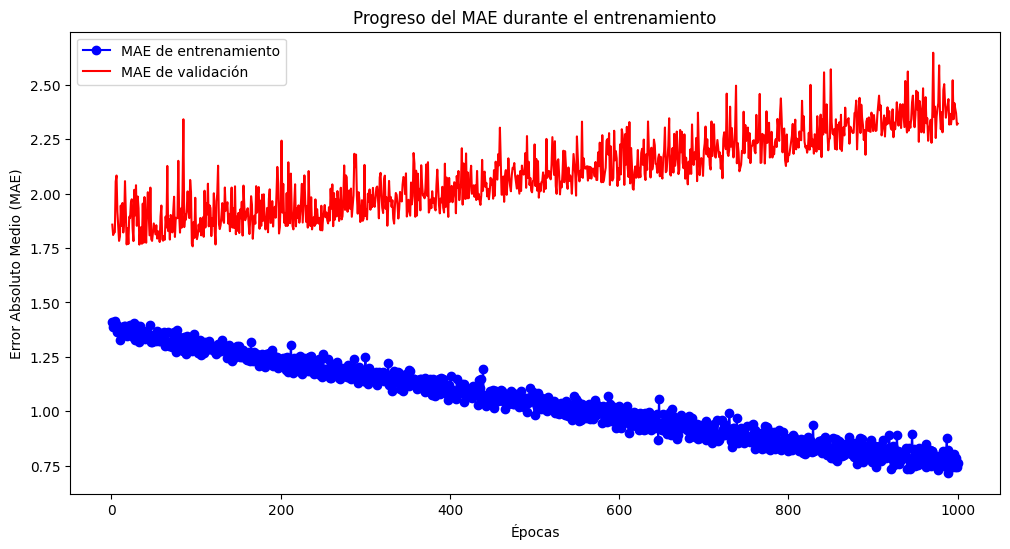

In [17]:
import matplotlib.pyplot as plt

# Extraer los datos del historial
history_dict = history.history

# Recuperar las métricas
loss = history_dict['loss']
val_loss = history_dict['val_loss']
mae = history_dict['mae']
val_mae = history_dict['val_mae']

# Crear un rango de épocas
epochs = range(1, len(loss) + 1)

# Plot de la pérdida
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'bo-', label='Pérdida de entrenamiento')
plt.plot(epochs, val_loss, 'r-', label='Pérdida de validación')
plt.title('Progreso de la pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Plot de MAE
plt.figure(figsize=(12, 6))
plt.plot(epochs, mae, 'bo-', label='MAE de entrenamiento')
plt.plot(epochs, val_mae, 'r-', label='MAE de validación')
plt.title('Progreso del MAE durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Error Absoluto Medio (MAE)')
plt.legend()
plt.show()


¿Alguna conclusión respecto a este gráfico?

Pérdida:

La pérdida de entrenamiento (azul) disminuye constantemente a lo largo de las épocas, indicando que el modelo está aprendiendo a ajustarse a los datos de entrenamiento.
La pérdida de validación (rojo) se mantiene alta y fluctuante, incluso incrementándose hacia el final del entrenamiento. Esto es un claro signo de sobreajuste. El modelo aprende demasiado los patrones del conjunto de entrenamiento y no generaliza bien a los datos de validación.
Error Absoluto Medio (MAE):

El MAE en entrenamiento sigue una tendencia descendente, lo que confirma que el modelo mejora en el ajuste a los datos de entrenamiento.
El MAE de validación sigue un patrón errático y no mejora, corroborando que el modelo tiene problemas para generalizar.

Añade un early stopping al modelo. Pon el argumento `callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]` dentro del fit().

Visualiza el progreso de entrenamiento.

Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.3599 - mae: 0.7738 - mse: 1.3599 - val_loss: 10.5682 - val_mae: 2.3518 - val_mse: 10.5682
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4109 - mae: 0.7083 - mse: 1.4109 - val_loss: 9.8244 - val_mae: 2.2792 - val_mse: 9.8244
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0789 - mae: 0.6595 - mse: 1.0789 - val_loss: 10.1232 - val_mae: 2.2924 - val_mse: 10.1232
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1795 - mae: 0.7030 - mse: 1.1795 - val_loss: 11.3950 - val_mae: 2.4056 - val_mse: 11.3950
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4592 - mae: 0.7616 - mse: 1.4592 - val_loss: 11.6370 - val_mae: 2.4415 - val_mse: 11.6370
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9875 - mae: 0.8843 - mse: 1.9875 - val_loss: 11.8177 - val_mae: 2.4710 - val_mse: 11.8177
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8735 - mae: 0.7755 - mse: 1.8735 - 

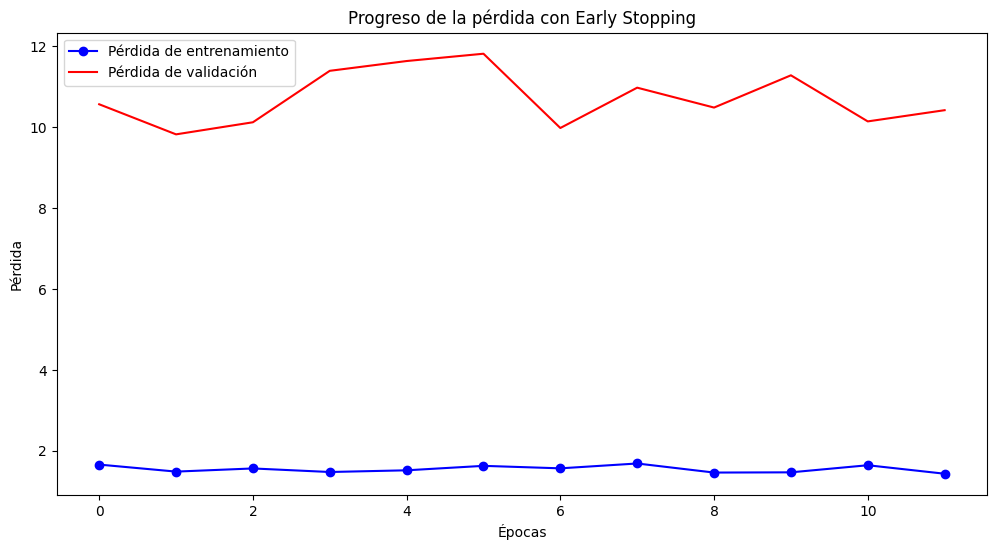

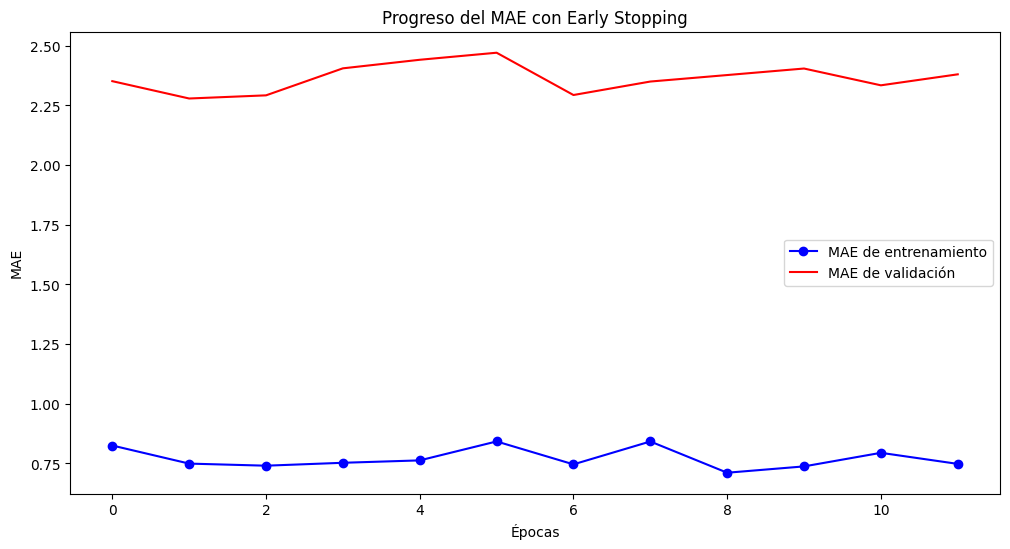

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Configuración del Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenamiento del modelo con Early Stopping
history_with_early_stopping = model.fit(
    train_features, train_target,  # Datos de entrenamiento
    epochs=1000,                  # Número máximo de épocas
    validation_split=0.2,         # Usar el 20% de los datos para validación
    callbacks=[early_stopping],   # Añadir Early Stopping
    verbose=1                     # Mostrar el progreso del entrenamiento
)

# Visualización del progreso del entrenamiento
history_dict = history_with_early_stopping.history

# Pérdida
plt.figure(figsize=(12, 6))
plt.plot(history_dict['loss'], 'bo-', label='Pérdida de entrenamiento')
plt.plot(history_dict['val_loss'], 'r-', label='Pérdida de validación')
plt.title('Progreso de la pérdida con Early Stopping')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# MAE
plt.figure(figsize=(12, 6))
plt.plot(history_dict['mae'], 'bo-', label='MAE de entrenamiento')
plt.plot(history_dict['val_mae'], 'r-', label='MAE de validación')
plt.title('Progreso del MAE con Early Stopping')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()
plt.show()


Interpreta el gráfico

Gráfico de pérdida:
Pérdida de entrenamiento (línea azul):

La pérdida en el conjunto de entrenamiento es consistentemente baja y estable. Esto indica que el modelo está ajustándose bien a los datos de entrenamiento.
Pérdida de validación (línea roja):

La pérdida en el conjunto de validación es significativamente mayor y presenta oscilaciones. Esto podría ser un indicio de que el modelo aún tiene problemas para generalizar, incluso con el Early Stopping.
Las oscilaciones sugieren que los datos de validación pueden ser ruidosos o que el modelo tiene una capacidad limitada para generalizar.
Gráfico de MAE:
MAE de entrenamiento (línea azul):

El MAE en el entrenamiento es bajo y consistente, mostrando que el modelo es preciso al predecir los valores dentro del conjunto de entrenamiento.
MAE de validación (línea roja):

El MAE de validación es mayor y sigue un patrón similar al de la pérdida, con fluctuaciones significativas. Esto refuerza la conclusión de que el modelo tiene dificultades para generalizar.

Veamos qué tan bien generaliza el modelo al usar el conjunto de **test**. Esto nos dice qué tan bien podemos esperar que el modelo prediga cuándo lo usamos en el mundo real. Utiliza el método `evaluate` con los datos de test normalizados y sus labels.

Con el método evaluate devolverá tres valores: loss, mae y mse.

In [19]:
# Evaluar el modelo en el conjunto de prueba
test_results = model.evaluate(test_features, test_target, verbose=1)

# Mostrar los resultados
test_loss, test_mae, test_mse = test_results
print(f"Pérdida en el conjunto de prueba (loss): {test_loss:.4f}")
print(f"Error Absoluto Medio en el conjunto de prueba (MAE): {test_mae:.4f}")
print(f"Error Cuadrático Medio en el conjunto de prueba (MSE): {test_mse:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.9249 - mae: 2.0990 - mse: 7.9249
Pérdida en el conjunto de prueba (loss): 8.2002
Error Absoluto Medio en el conjunto de prueba (MAE): 2.1013
Error Cuadrático Medio en el conjunto de prueba (MSE): 8.2002


Ahora prueba el modelo. Coge 10 ejemplos de test y llama a` model.evaluate`.

In [20]:
# Seleccionar 10 ejemplos del conjunto de prueba
sample_features = test_features[:10]
sample_target = test_target[:10]

# Evaluar el modelo en los 10 ejemplos seleccionados
sample_results = model.evaluate(sample_features, sample_target, verbose=1)

# Mostrar los resultados para los 10 ejemplos
sample_loss, sample_mae, sample_mse = sample_results
print(f"Pérdida en los 10 ejemplos (loss): {sample_loss:.4f}")
print(f"Error Absoluto Medio en los 10 ejemplos (MAE): {sample_mae:.4f}")
print(f"Error Cuadrático Medio en los 10 ejemplos (MSE): {sample_mse:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 7.5982 - mae: 2.1346 - mse: 7.5982
Pérdida en los 10 ejemplos (loss): 7.5982
Error Absoluto Medio en los 10 ejemplos (MAE): 2.1346
Error Cuadrático Medio en los 10 ejemplos (MSE): 7.5982


### Haz Predicciones

Dibuja en un scatter plot las predicciones de test vs sus true labels.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


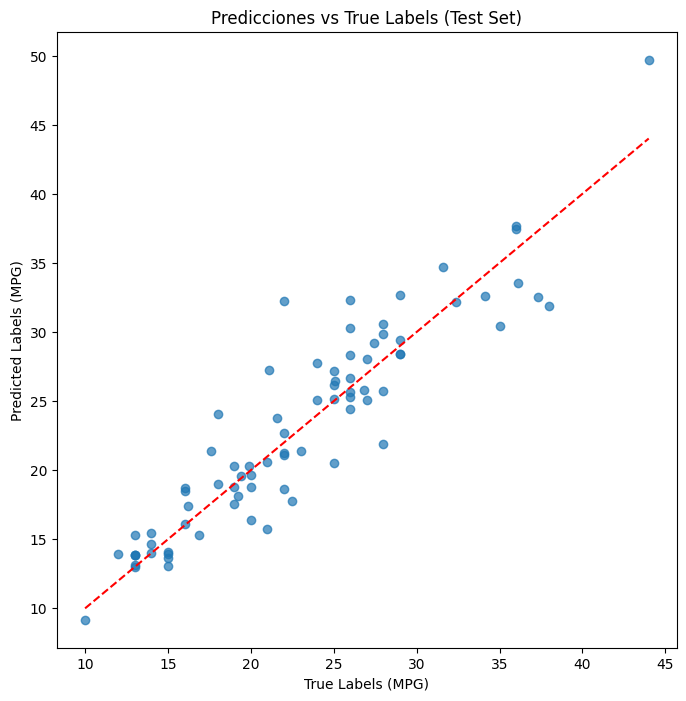

In [21]:
# Hacer predicciones en el conjunto de prueba
test_predictions = model.predict(test_features).flatten()

# Dibujar scatter plot de predicciones vs true labels
plt.figure(figsize=(8, 8))
plt.scatter(test_target, test_predictions, alpha=0.7)
plt.xlabel('True Labels (MPG)')
plt.ylabel('Predicted Labels (MPG)')
plt.title('Predicciones vs True Labels (Test Set)')
plt.plot([test_target.min(), test_target.max()], [test_target.min(), test_target.max()], 'r--')
plt.show()


Parece que nuestro modelo predice razonablemente bien. Echemos un vistazo a la distribución de errores.

Representa los residuos en un histograma

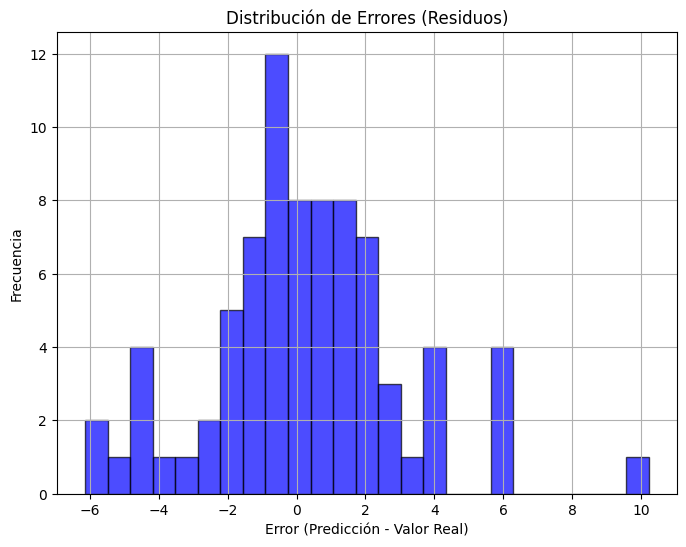

In [22]:
# Calcular los residuos (errores)
errors = test_predictions - test_target

# Dibujar un histograma de los errores
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=25, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribución de Errores (Residuos)')
plt.xlabel('Error (Predicción - Valor Real)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


No es del todo gaussiano, pero podríamos esperar eso porque el número de muestras es muy pequeño.

Guarda tu modelo en un archivo.

In [23]:
# Guardar el modelo en un archivo
model.save('auto_mpg_model.h5')

print("El modelo se ha guardado exitosamente en el archivo 'auto_mpg_model.h5'.")


El modelo se ha guardado exitosamente en el archivo 'auto_mpg_model.h5'.
